In [1]:
!pip install catboost

In [2]:
!pip install albumentations -q

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # da ta processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
#import cv2
import re

In [4]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import catboost as cb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [5]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

In [6]:
# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

import seaborn as sns

In [7]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [8]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [9]:
!pip freeze > requirements.txt

In [10]:
!pip install -q tensorflow==2.3

In [11]:
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [12]:
downloaded = drive.CreateFile({'id':"1dXPQt0eXE5DVpOpkDSpwRH5O7cA-5OX2"})   # replace the id with id of file you want to access
downloaded.GetContentFile('train.csv.zip') 
downloaded = drive.CreateFile({'id':"1b04b2b5aJA9rN-zDN2mhTTRXrZkztewO"})   # replace the id with id of file you want to access
downloaded.GetContentFile('test.csv.zip') 
downloaded = drive.CreateFile({'id':"1xhKzs3_0UNI50Rx1g0h-xwtjmES2BdKe"})   # replace the id with id of file you want to access
downloaded.GetContentFile('sample_submission.csv') 

In [13]:
DATA_DIR = './'
train = pd.read_csv(DATA_DIR + 'train.csv.zip')
test = pd.read_csv(DATA_DIR + 'test.csv.zip')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [15]:
train

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6677,седан,BMW,серый,Продаётся любимый автомобиль! За годы эксплуат...,2.0 LTR,150 N12,бензин,232777,2005,3ER,320i 2.0 AT (150 л.с.),4,550000.0,2006,1100036650,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,NaN,Оригинал,задний,Левый
6678,седан,BMW,чёрный,Куплена у официального дилера в 2017 г. \n\nТр...,2.0 LTR,190 N12,дизель,33700,2013,5ER,520d 2.0d AT (190 л.с.),4,1900000.0,2016,1090506038,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,2 года и 2 месяца,Оригинал,задний,Левый
6679,седан,BMW,белый,Торг на месте. Все работает. Сборка немецкая. ...,2.0 LTR,143 N12,бензин,200000,2008,3ER,318i 2.0 AT (143 л.с.),4,530000.0,2008,1095155628,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,2 года и 2 месяца,Оригинал,задний,Левый
6680,седан,AUDI,чёрный,Автомобиль в отличном состоянии.\n3-из Авто в ...,3.0 LTR,310 N12,бензин,72000,2013,A8,Long 3.0 AT (310 л.с.) 4WD,4,1970000.0,2016,1099625256,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый


In [16]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [17]:
data_train, data_test = train_test_split(train, test_size=0.30, shuffle=True, random_state=RANDOM_SEED)

In [18]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 20.15%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

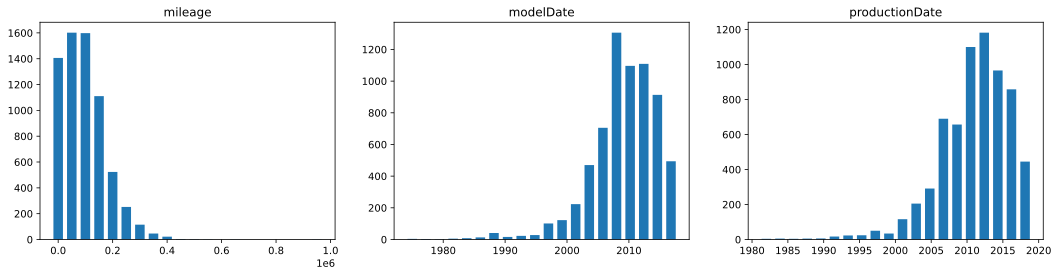

In [19]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:

    CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [20]:
#целевая переменная
#train['price']=train['price'].apply(lambda x: np.log(x))

In [21]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [22]:
data.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                5418
ПТС                        0
Привод                     0
Руль                       0
sample                     0
price                      0
dtype: int64

In [23]:
data.sample(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
7399,внедорожник 5 дв.,BMW,коричневый,"Авто в одних руках,все обслуживание по реглам...",2.0 LTR,245 N12,бензин,107000,2014,X3,28i xDrive 2.0 AT (245 л.с.) 4WD,5,2015,1091374938,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,1 владелец,4 года и 9 месяцев,Оригинал,полный,Левый,1,1590000.0
4273,внедорожник 5 дв.,BMW,чёрный,"Год выпуска 2016, приобрел новую без пробега в...",2.0 LTR,245 N12,гибрид,45000,2013,X5,40e 2.0hyb AT (245 л.с.) 4WD,5,2016,1099098578,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,1 владелец,2 года и 6 месяцев,Оригинал,полный,Левый,1,3100000.0
3362,седан,MERCEDES,чёрный,В идеальном состоянии. Обслуживание в Панавто ...,5.5 LTR,585 N12,бензин,55000,2013,S_KLASSE_AMG,63 AMG Long 5.5 AT (585 л.с.) 4WD,4,2015,1094635516,SEDAN AUTOMATIC 5.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,1,3750000.0


In [24]:
data.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
       'sample', 'price'],
      dtype='object')

In [25]:
data['name'].unique()

array(['300 3.0 AT (220 л.с.)', '640d xDrive 3.0d AT (313 л.с.) 4WD',
       '325xi 2.5 AT (218 л.с.) 4WD', '318i 2.0 AT (136 л.с.)',
       '520d xDrive 2.0d AT (190 л.с.) 4WD',
       '540i xDrive 3.0 AT (340 л.с.) 4WD', '3.0d AT (245 л.с.) 4WD',
       '350 3.5 AT (316 л.с.)', '1.8 CVT (170 л.с.)',
       '1.8 CVT (160 л.с.)', '300 3.0 AT (231 л.с.)',
       '320i 2.2 AT (170 л.с.)', '500 5.5 AT (388 л.с.) 4WD',
       '2.0 CVT (180 л.с.)', '650i 4.8 AT (367 л.с.)',
       '116i 1.6 AT (115 л.с.)', '320i 2.0 AT (184 л.с.)',
       '25d 3.0d AT (218 л.с.) 4WD', '20d 2.0d AT (177 л.с.) 4WD',
       '500 4.7 AT (455 л.с.) 4WD', '330i 3.0 AT (231 л.с.)',
       '1.8 AMT (190 л.с.)', '500 4x4 4.0 AT (422 л.с.) 4WD',
       '200 2.0 AT (184 л.с.) 4WD', '1.8 CVT (163 л.с.)',
       '320d 2.0d AT (163 л.с.)', '118i 1.5 AT (136 л.с.)',
       '30d 3.0d AT (249 л.с.) 4WD', '630i 3.0 AT (272 л.с.)',
       '2.4 CVT (177 л.с.)', '318i 1.5 AT (136 л.с.)',
       '320 3.0d AT (224 л.с.) 4WD', '2.

In [26]:
#def Clean_names(name):
 #   if re.search('\(.*', name):
  #     pos = re.search('\(.*', name).start()
  #      result=name[:pos].replace('xDrive','')
  #  else:
  #      result=name.replace('xDrive','')
  #  return result

In [27]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id', 'name','Владельцы','ПТС'], axis = 1, inplace=True)
    
    # ################### Feature Engineering ####################################################
    #Владение
    def num_of_months(row):
        if pd.notnull(row):
            list_ownership = row.split()
            if len(list_ownership) == 2:
                if list_ownership[1] in ['год', 'года', 'лет']:
                    return int(list_ownership[0])*12
                return int(list_ownership[0])
            return int(list_ownership[0])*12 + int(list_ownership[3])
    df_output['Владение'] = df_output['Владение'].apply(num_of_months)
    
    # enginePower, оставим только цифру в enginePower
    df_output['enginePower'] = df_output['enginePower'].apply(lambda x: int(x.split()[0]))
    
     # engineDisplacement, оставим только цифру в engineDisplacement
    df_output['engineDisplacement'][df_output['engineDisplacement'] == 'undefined LTR'] = 'NaN'    
    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(lambda x: float(x.split()[0]))
    
    #новый признак- наличие или отсутствие 4WD (все колеса ведущие)
    #df_output['4wd'] = df_output['name'].apply(lambda x: 0 if x.find('4WD')==-1 else 1)
    
    #новый признак- наличие или отсутствие xDrive
    #df_output['xDrive'] = df_output['name'].apply(lambda x: 0 if x.find('xDrive')==-1 else 1)
    
    #сокращение name
    #df_output['name'] = df_output['name'].apply(Clean_names)
    
    #df_output['Владельцы']=df_output['Владельцы'].fillna('1\xa0владелец')

    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
        if column == 'modelDate':
            df_output['modelDate'] = np.log(2020 - data['modelDate'])
        else:
            df_output[column]=df_output[column].apply(lambda x: np.log(x))
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    df_output=df_output.dropna()
    
    return df_output

In [28]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', #'name',
  'numberOfDoors', 'vehicleTransmission', 'Привод', 'Руль']#'Владельцы' 'ПТС'

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate','Владение','enginePower','engineDisplacement']

In [29]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владение,sample,price,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,...,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
3640,0.467888,0.439126,0.891384,0.638495,0.686257,0.840323,1,630000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0
6421,0.467888,0.310328,0.866257,0.616137,0.791046,0.619468,1,680000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0
7645,0.420931,0.339223,0.829621,0.659062,0.712474,0.619468,1,599000.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0
7222,0.467888,0.529985,0.757345,0.413544,0.895627,0.619468,1,2150000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0
4604,0.648598,0.553132,0.852324,0.616137,0.791046,0.619468,1,1290000.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0
5140,0.275896,0.310328,0.673618,0.178104,0.973926,0.619468,1,1898000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0
728,0.420931,0.339223,0.866900,0.659062,0.764868,0.354121,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0
7029,0.567340,0.477709,0.830379,0.742679,0.633785,0.449422,1,675000.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0
1997,0.648598,0.629523,0.893054,0.659062,0.712474,0.619468,1,970000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0
3433,0.467888,0.463097,0.867353,0.564575,0.791046,0.619468,1,890000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0


In [30]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8353 entries, 0 to 8352
Columns: 183 entries, engineDisplacement to Руль_1
dtypes: float64(7), int64(1), uint8(175)
memory usage: 2.0 MB


In [31]:
# фукция для построения распределния и получения данных по iqr
def iqr(q):
    median = q.median()
    IQR = q.quantile(0.75) - q.quantile(0.25)
    perc25 = q.quantile(0.25)
    perc75 = q.quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),"IQR: {}, \
          ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    sns.distplot(q.loc[q.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)])

25-й перцентиль: 0.7954431723722861, 75-й перцентиль: 0.8704891439584888, IQR: 0.07504597158620263,            Границы выбросов: [0.6828742149929822, 0.9830581013377927].


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


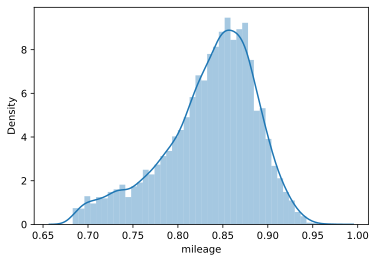

In [32]:
iqr(df_preproc['mileage'])

25-й перцентиль: 460000.0, 75-й перцентиль: 1900000.0, IQR: 1440000.0,            Границы выбросов: [-1700000.0, 4060000.0].


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


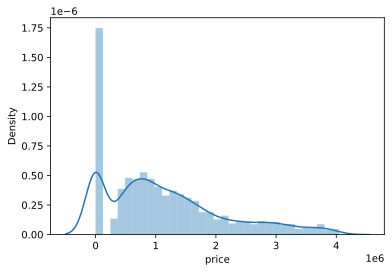

In [33]:
iqr(df_preproc['price'])

25-й перцентиль: 0.4603911105808009, 75-й перцентиль: 0.6590616115309205, IQR: 0.19867050095011957,            Границы выбросов: [0.16238535915562152, 0.9570673629560998].


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


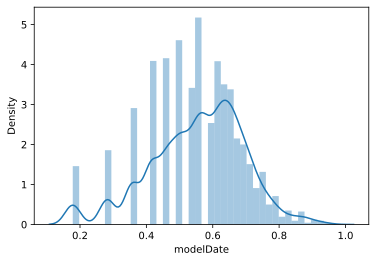

In [34]:
iqr(df_preproc['modelDate'])

25-й перцентиль: 0.712474126134282, 75-й перцентиль: 0.8956267008977079, IQR: 0.18315257476342595,            Границы выбросов: [0.43774526398914304, 1.1703555630428468].


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


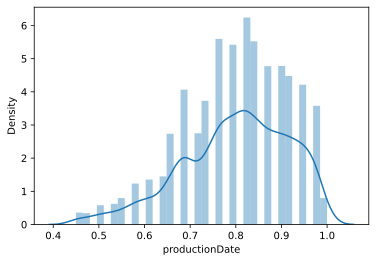

In [35]:
iqr(df_preproc['productionDate'])

count    8353.000000
mean        0.614141
std         0.087592
min         0.000000
25%         0.619468
50%         0.619468
75%         0.619468
max         1.000000
Name: Владение, dtype: float64

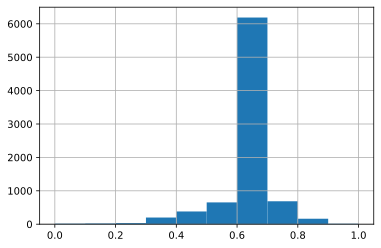

In [36]:
df_preproc['Владение'].hist()
df_preproc['Владение'].describe()

25-й перцентиль: 0.4017956525059585, 75-й перцентиль: 0.6295226921355055, IQR: 0.227727039629547,            Границы выбросов: [0.060205093061638015, 0.971113251579826].


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


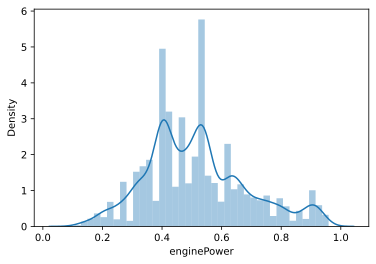

In [37]:
iqr(df_preproc['enginePower'])

25-й перцентиль: 0.4678884253526061, 75-й перцентиль: 0.6485975441080779, IQR: 0.1807091187554718,            Границы выбросов: [0.1968247472193984, 0.9196612222412857].


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


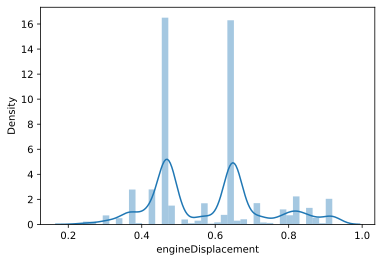

In [38]:
iqr(df_preproc['engineDisplacement'])

## Split data

In [39]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [40]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 182 entries, engineDisplacement to Руль_1
dtypes: float64(7), uint8(175)
memory usage: 390.0 KB


# Model 2: CatBoostRegressor

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [42]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.023474
0:	learn: 0.9865342	test: 1.0105737	best: 1.0105737 (0)	total: 49.8ms	remaining: 4m 8s
100:	learn: 0.2996301	test: 0.3001372	best: 0.3001275 (99)	total: 330ms	remaining: 16s
200:	learn: 0.2351750	test: 0.2335744	best: 0.2335744 (200)	total: 605ms	remaining: 14.5s
300:	learn: 0.1991956	test: 0.1981523	best: 0.1981523 (300)	total: 878ms	remaining: 13.7s
400:	learn: 0.1825548	test: 0.1830305	best: 0.1830305 (400)	total: 1.15s	remaining: 13.2s
500:	learn: 0.1760103	test: 0.1778768	best: 0.1778768 (500)	total: 1.43s	remaining: 12.9s
600:	learn: 0.1672064	test: 0.1700182	best: 0.1700182 (600)	total: 1.71s	remaining: 12.5s
700:	learn: 0.1590247	test: 0.1627016	best: 0.1625978 (699)	total: 1.97s	remaining: 12.1s
800:	learn: 0.1533892	test: 0.1581479	best: 0.1581479 (800)	total: 2.24s	remaining: 11.7s
900:	learn: 0.1491292	test: 0.1557754	best: 0.1556546 (891)	total: 2.51s	remaining: 11.4s
1000:	learn: 0.1448671	test: 0.1522253	best: 0.1522253 (1000)	total: 2.78s	r

In [43]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.63%


### Submission

In [44]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission['price'] = sample_submission['price'].apply(lambda x: np.exp(x))
#sample_submission['price'] = sample_submission['price'].apply(lambda x: round(x/1000)*1000)
sample_submission.to_csv('catboost_submission.csv', index=False)

In [45]:
sample_submission.price

0       inf
1       inf
2       inf
3       inf
4       inf
       ... 
1666    inf
1667    inf
1668    inf
1669    inf
1670    inf
Name: price, Length: 1671, dtype: float64

# NLP


In [46]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владение,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,...,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7320,0.957522,0.887119,0.862682,0.638495,0.764868,0.803543,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0
8037,0.467888,0.529985,0.720170,0.356207,0.947839,0.619468,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0
4681,0.663211,0.547896,0.854462,0.712414,0.633785,0.619468,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0
6014,0.420931,0.401796,0.919752,0.678104,0.660028,0.744101,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0
3649,0.648598,0.639649,0.850062,0.564575,0.817211,0.741931,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0


In [47]:
model = Sequential()
model.add(L.Dense(1024, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(512, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              186368    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 711,681
Trainable params: 711,681
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [50]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [51]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

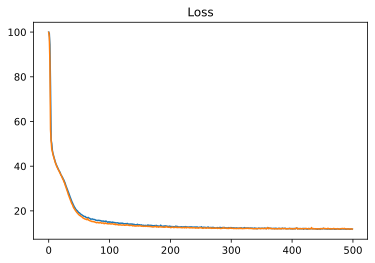

In [52]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [53]:
model.load_weights('best_model.hdf5')
model.save('model1.hdf5')

In [54]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.83%


In [55]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
#sample_submission['price'] = sample_submission['price'].apply(lambda x: np.exp(x))
#sample_submission['price'] = sample_submission['price'].apply(lambda x: round(x/1000)*1000)
sample_submission.to_csv('model1_submission.csv', index=False)

#  Multi-Input сеть: табличные данные + текст


In [56]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [57]:
!pip install pymorphy2

In [58]:
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [59]:
patterns = r"[A-Za-z0-9^\W]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    return tokens

In [60]:
%%time
data.description = data.description.apply(lemmatize)

CPU times: user 1min 51s, sys: 21.8 ms, total: 1min 51s
Wall time: 1min 51s


In [61]:
from collections import defaultdict

In [62]:
word_freq = defaultdict(int)
for tokens in data.description.dropna():
    for token in tokens:
        word_freq[token] += 1

In [63]:
len(word_freq)

13617

In [64]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['автомобиль',
 'система',
 'пробег',
 'задний',
 'салон',
 'сидение',
 'год',
 'состояние',
 'передний',
 'машина']

In [65]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [66]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

Tokenizer

In [67]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 417 ms, sys: 4.51 ms, total: 421 ms
Wall time: 425 ms


In [68]:
tokenize.word_index

{'автомобиль': 1,
 'система': 2,
 'пробег': 3,
 'задний': 4,
 'салон': 5,
 'сидение': 6,
 'год': 7,
 'состояние': 8,
 'передний': 9,
 'машина': 10,
 'диск': 11,
 'комплект': 12,
 'в': 13,
 'дилер': 14,
 'новый': 15,
 'официальный': 16,
 'ваш': 17,
 'кредит': 18,
 'фара': 19,
 'авто': 20,
 'гарантия': 21,
 'пакет': 22,
 'руль': 23,
 'всё': 24,
 'колесо': 25,
 'безопасность': 26,
 'комплектация': 27,
 'вы': 28,
 'обмен': 29,
 'птс': 30,
 'контроль': 31,
 'зеркало': 32,
 'проверка': 33,
 'покупка': 34,
 'продажа': 35,
 'водитель': 36,
 'полный': 37,
 'шина': 38,
 'датчик': 39,
 'км': 40,
 'отличный': 41,
 'пассажир': 42,
 'двигатель': 43,
 'резина': 44,
 'условие': 45,
 'владелец': 46,
 'ключ': 47,
 'то': 48,
 'кузов': 49,
 'подушка': 50,
 'подогрев': 51,
 'обогрев': 52,
 'технический': 53,
 'любой': 54,
 'обслуживание': 55,
 'хороший': 56,
 'два': 57,
 'юридический': 58,
 'оригинал': 59,
 'стекло': 60,
 'торг': 61,
 'масло': 62,
 'м': 63,
 'дверь': 64,
 'замена': 65,
 'чёрный': 66,
 'про

In [69]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

CPU times: user 373 ms, sys: 4.8 ms, total: 378 ms
Wall time: 382 ms


In [70]:
print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)


In [71]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

['автомобиль', 'проверить', 'пункт', 'автокредит', 'специальный', 'ставка', 'ауди', 'центр', 'север', 'официальный', 'дилер', 'входящий', 'группа', 'компания', 'рольф', 'являться', 'один', 'крупный', 'дилер', 'европа', 'предлагать', 'вы', 'ряд', 'услуга', 'покупка', 'продажа', 'автомобиль', 'пробег', 'на', 'протяжение', 'многий', 'год', 'наш', 'дилерский', 'центр', 'являться', 'лидер', 'продажа', 'автомобиль', 'пробег', 'среди', 'дилер', 'россия', 'предоставлять', 'клиент', 'самый', 'большой', 'выбор', 'автомобиль', 'пробег', 'другой', 'марка', 'каждый', 'автомобиль', 'проходить', 'тщательный', 'диагностик', 'подготовка', 'гарантировать', 'находиться', 'отличный', 'состояние', 'чтобы', 'убедиться', 'правильный', 'выбор', 'вы', 'возможность', 'пройти', 'тест', 'драйв', 'ознакомительный', 'поездка', 'интересовать', 'автомобиль', 'вы', 'смочь', 'ознакомиться', 'автомобиль', 'выходить', 'дом', 'наш', 'менеджер', 'провести', 'презентация', 'видеозвонок', 'показать', 'выбрать', 'автомобиль',

RNN NLP

In [72]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

MLP

In [73]:
model_mlp = Sequential()
model_mlp.add(L.Dense(1024, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(512, activation="relu"))
model_mlp.add(L.Dropout(0.5))

Multiple Inputs NN

In [74]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [75]:
model.summary()#102030001-101

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     3486208     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

#FIT

In [76]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [77]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [78]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 4s 331ms/step - loss: 99.9254 - MAPE: 99.9254 - val_loss: 99.0979 - val_MAPE: 99.0979
Epoch 2/500
12/12 [==============================] - 3s 269ms/step - loss: 92.0926 - MAPE: 92.0926 - val_loss: 65.5554 - val_MAPE: 65.5554
Epoch 3/500
12/12 [==============================] - 3s 267ms/step - loss: 55.3076 - MAPE: 55.3076 - val_loss: 49.6146 - val_MAPE: 49.6146
Epoch 4/500
12/12 [==============================] - 3s 266ms/step - loss: 48.3407 - MAPE: 48.3407 - val_loss: 45.9558 - val_MAPE: 45.9558
Epoch 5/500
12/12 [==============================] - 3s 268ms/step - loss: 45.1756 - MAPE: 45.1756 - val_loss: 43.6864 - val_MAPE: 43.6864
Epoch 6/500
12/12 [==============================] - 3s 267ms/step - loss: 42.7750 - MAPE: 42.7750 - val_loss: 41.8007 - val_MAPE: 41.8007
Epoch 7/500
12/12 [==============================] - 3s 268ms/step - loss: 40.9605 - MAPE: 40.9605 - val_loss: 40.2905 - val_MAPE: 40.2905
Epoch 8/500
12/12 [========

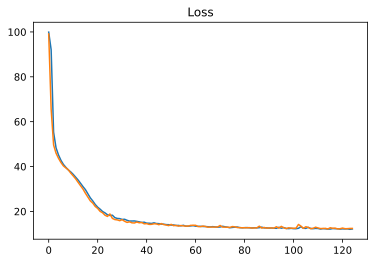

In [79]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [80]:
model.load_weights('best_model.hdf5')
model.save('nn_mlp_nlp.hdf5')

In [81]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.41%


In [82]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)